### All Imports

In [2]:
import glob
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Lambda
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dropout
from keras.layers import Flatten

%matplotlib inline
import matplotlib.pylab as plt

C:\Users\Rabel\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reading Image Files

In [2]:
cars = glob.glob("./vehicles/*.png")
non_cars = glob.glob("./non-vehicles/*.png")
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])
X = []
for name in cars:
    rgb = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    X.append(rgb)
for name in non_cars:
    rgb = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    X.append(rgb)
X = np.array(X)
print("Total Test Data", len(X))
print("Total Labeled", len(Y))

Total Test Data 15339
Total Labeled 15339


### Preprocessing

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
img_width = 64
img_height = 64
input_shape = (img_width, img_height, 3)

print('X_train Shape', X_train.shape)
print('Train Sampls:', X_train.shape[0])
print('Test Samples', X_test.shape[0])

X_train Shape (13805, 64, 64, 3)
Train Sampls: 13805
Test Samples 1534


### Using Keras Model in Classification Mode

In [4]:
def create_model(input_shape = (64,64,3), filename = None):
    
    model = Sequential()
    model.add(Lambda(lambda x: x/255, input_shape = input_shape, output_shape = input_shape))
    
    conv1 = Conv2D(10, (3, 3), activation = 'relu', name = 'conv1', input_shape = input_shape, padding = 'same')
    model.add(conv1)

    conv2 = Conv2D(10, (3, 3), activation = 'relu', name = 'conv2', input_shape = input_shape, padding = 'same')
    model.add(conv2)
    
    conv3 = Conv2D(10, (3, 3), activation = 'relu', name = 'conv3', input_shape = input_shape, padding = 'same')
    model.add(conv3)
    
    pool = MaxPool2D(pool_size = (8, 8))
    model.add(pool)
    
    model.add(Dropout(0.25))
    
    dense1 = Conv2D(128, (8, 8), activation = 'relu', name = 'dense1')
    model.add(dense1)
    
    model.add(Dropout(0.5))
    
    dense2 = Conv2D(1, (1, 1), activation = 'tanh', name = 'dense2')
    model.add(dense2)
    
    
    if filename:
        model.load_weights(filename)
    return model
    
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 10)        280       
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 10)        910       
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 10)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 10)          0         
_________________________________________________________________
dense1 (Conv2D)              (None, 1, 1, 128)         82048     
__________

### Prdection of the Model

In [13]:
model.add(Flatten())
model.compile(loss = 'mse', optimizer = 'adadelta', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 128, epochs = 5, verbose = 1, validation_data = (X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose = 0)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])
model.save_weights("heatmap_data.h5")
print("Model Saved")

Train on 13805 samples, validate on 1534 samples
Epoch 1/5
13805/13805 [==============================] - 93s 7ms/step - loss: 0.5527 - acc: 0.4821 - val_loss: 0.2149 - val_acc: 0.8305
Epoch 2/5
13805/13805 [==============================] - 92s 7ms/step - loss: 0.1278 - acc: 0.9082 - val_loss: 0.0745 - val_acc: 0.9596
Epoch 3/5
13805/13805 [==============================] - 97s 7ms/step - loss: 0.0697 - acc: 0.9523 - val_loss: 0.0320 - val_acc: 0.9759
Epoch 4/5
13805/13805 [==============================] - 100s 7ms/step - loss: 0.0503 - acc: 0.9678 - val_loss: 0.0326 - val_acc: 0.9778
Epoch 5/5
13805/13805 [==============================] - 96s 7ms/step - loss: 0.0412 - acc: 0.9748 - val_loss: 0.0194 - val_acc: 0.9889
Test Score: 0.019379290194472848
Test Accuracy: 0.9889178617992177
Model Saved


### HeatMap

In [8]:
heatmodel = create_model(input_shape=(None, None, 3), filename = 'heatmap_data.h5')

In [1]:
def locate():
    data = cv2.cvtColor(cv2.imread("Mytest/test3.jpg"), cv2.COLOR_BGR2RGB)
    
    height = data.shape[0]
    width = data.shape[1]
    depth = data.shape[2]
    # 720,1280,3
    heatmap = heatmodel.predict(data.reshape(1, height, width, depth))
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Car Area")
    plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate()

plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

NameError: name 'cv2' is not defined

### Predicting New Data

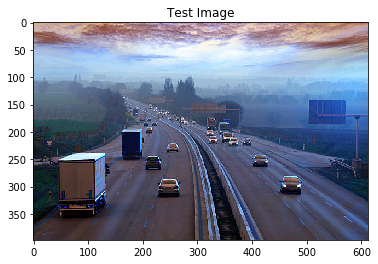

Class:
Vehicle


In [43]:
# predicting images
from keras.preprocessing import image
import cv2

image_file_name = 'Mytest/test2.jpg'
plt.title("Test Image")    
plt.imshow(cv2.imread(image_file_name))
plt.show()

width = 64
height = 64
img = image.load_img(image_file_name, target_size=(width, height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)

output_class = classes[0][0]
print("Class:")
if output_class == 1:
    print("Vehicle")
else:
    print("Non-Vehicle")